In [1]:
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans


c:\Users\Yusuf\Documents\Semester 9\DE\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('accepted_2007_to_2018Q4.csv')

df.head()

C:\Users\Yusuf\AppData\Local\Temp\ipykernel_33884\1349115024.py:1: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('accepted_2007_to_2018Q4.csv')


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,66310712,NaN,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,68476807,NaN,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


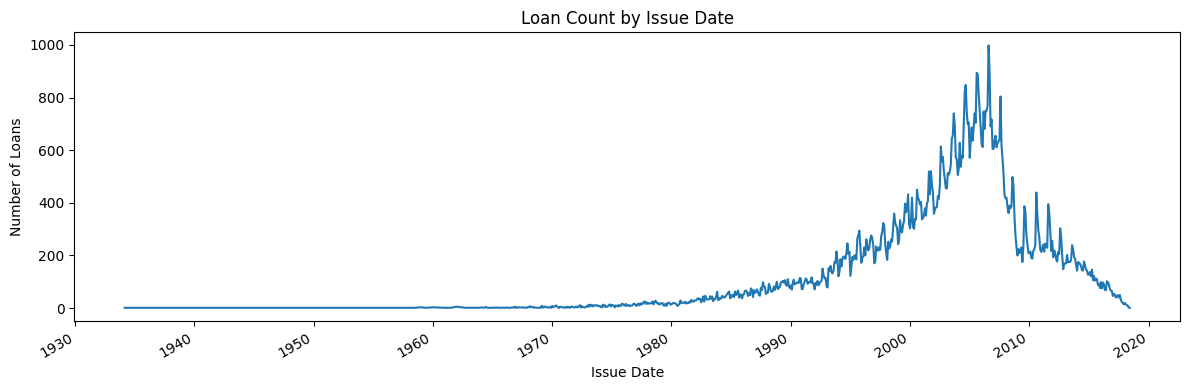

In [3]:
import matplotlib.pyplot as plt

issue_dates = pd.to_datetime(df['sec_app_earliest_cr_line'], format='%b-%Y', errors='coerce')
issue_counts = issue_dates.value_counts().sort_index()

plt.figure(figsize=(12, 4))
issue_counts.plot(kind='line')
plt.xlabel('Issue Date')
plt.ylabel('Number of Loans')
plt.title('Loan Count by Issue Date')
plt.tight_layout()
plt.show()

In [4]:
for col in df.columns:
    print(col, ': ', df[col].unique() if df[col].nunique() < 1000 else 'Too many unique values', df[col].nunique(), ' | Missing Percentage: ', df[col].isna().mean())
    if df[col].nunique() > 1000:
        print(df[col].value_counts().head(10))
    

id :  Too many unique values 2260701  | Missing Percentage:  0.0
id
68407277    1
68355089    1
68341763    1
66310712    1
68476807    1
68426831    1
68476668    1
67275481    1
68466926    1
68616873    1
Name: count, dtype: int64
member_id :  [nan] 0  | Missing Percentage:  1.0
loan_amnt :  Too many unique values 1572  | Missing Percentage:  1.4597242182845055e-05
loan_amnt
10000.0    187236
20000.0    131006
15000.0    123226
12000.0    121681
35000.0     86285
5000.0      84765
8000.0      75033
6000.0      72089
25000.0     66453
16000.0     66418
Name: count, dtype: int64
funded_amnt :  Too many unique values 1572  | Missing Percentage:  1.4597242182845055e-05
funded_amnt
10000.0    187146
20000.0    130816
15000.0    123110
12000.0    121588
35000.0     86147
5000.0      84751
8000.0      75020
6000.0      72075
16000.0     66331
25000.0     66176
Name: count, dtype: int64
funded_amnt_inv :  Too many unique values 10057  | Missing Percentage:  1.4597242182845055e-05
funded_amn

In [5]:
# Instead of dropping columns with >90% missing values, create a missing indicator
missing_threshold = 0.90
missing_percent = df.isnull().sum() / len(df)
cols_with_high_missing = missing_percent[missing_percent > missing_threshold].index.tolist()

print(f"Columns with >{missing_threshold*100}% missing values ({len(cols_with_high_missing)} columns):")
for col in cols_with_high_missing:
    print(f"  - {col}: {missing_percent[col]*100:.1f}% missing")

# For columns with high missing values:
# 1. Create a missing indicator column (0 for missing, 1 for not missing)
# 2. Replace missing values with 0
for col in cols_with_high_missing:
    # Create missing indicator column
    df[col + '_missing'] = (~df[col].isna()).astype(int)
    # Fill missing values with 0
    df[col] = df[col].fillna(0)

print(f"\nCreated {len(cols_with_high_missing)} missing indicator columns")
print(f"Replaced missing values with 0 for {len(cols_with_high_missing)} columns")

Columns with >90.0% missing values (38 columns):
  - member_id: 100.0% missing
  - desc: 94.4% missing
  - annual_inc_joint: 94.7% missing
  - dti_joint: 94.7% missing
  - verification_status_joint: 94.9% missing
  - revol_bal_joint: 95.2% missing
  - sec_app_fico_range_low: 95.2% missing
  - sec_app_fico_range_high: 95.2% missing
  - sec_app_earliest_cr_line: 95.2% missing
  - sec_app_inq_last_6mths: 95.2% missing
  - sec_app_mort_acc: 95.2% missing
  - sec_app_open_acc: 95.2% missing
  - sec_app_revol_util: 95.3% missing
  - sec_app_open_act_il: 95.2% missing
  - sec_app_num_rev_accts: 95.2% missing
  - sec_app_chargeoff_within_12_mths: 95.2% missing
  - sec_app_collections_12_mths_ex_med: 95.2% missing
  - sec_app_mths_since_last_major_derog: 98.4% missing
  - hardship_type: 99.5% missing
  - hardship_reason: 99.5% missing
  - hardship_status: 99.5% missing
  - deferral_term: 99.5% missing
  - hardship_amount: 99.5% missing
  - hardship_start_date: 99.5% missing
  - hardship_end_dat

#### Data Cleaning

In [ ]:


def map_loan_status(status):
    if pd.isna(status):
        return None
    
    status = str(status)
    
    good = [
        'Fully Paid',
        'Current',
        'In Grace Period',
        'Does not meet the credit policy. Status:Fully Paid'
    ]
    
    bad = [
        'Charged Off',
        'Default',
        'Late (31-120 days)',
        'Late (16-30 days)',
        'Does not meet the credit policy. Status:Charged Off'
    ]
    
    if status in good:
        return 0  # good
    else:
        return 1  # bad

df['loan_status_clean'] = df['loan_status'].apply(map_loan_status)
df = df.drop('loan_status', axis=1)

# Convert dates to cumulative days from minimum date
df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'], format='%b-%Y', errors='coerce')
df['earliest_cr_line_days'] = (df['earliest_cr_line'] - df['earliest_cr_line'].min()).dt.days
df = df.drop('earliest_cr_line', axis=1)

df['issue_d'] = pd.to_datetime(df['issue_d'])
df['issue_d_days'] = (df['issue_d'] - df['issue_d'].min()).dt.days
df = df.drop('issue_d', axis=1)

df['sec_app_earliest_cr_line'] = pd.to_datetime(df['sec_app_earliest_cr_line'], format='%b-%Y', errors='coerce')
df['sec_app_earliest_cr_line_days'] = (df['sec_app_earliest_cr_line'] - df['sec_app_earliest_cr_line'].min()).dt.days
df = df.drop('sec_app_earliest_cr_line', axis=1)

df['last_pymnt_d'] = pd.to_datetime(df['last_pymnt_d'], format='%b-%Y', errors='coerce')
df['last_pymnt_d_days'] = (df['last_pymnt_d'] - df['last_pymnt_d'].min()).dt.days
df = df.drop('last_pymnt_d', axis=1)

df['next_pymnt_d'] = pd.to_datetime(df['next_pymnt_d'], format='%b-%Y', errors='coerce')
df['next_pymnt_d_days'] = (df['next_pymnt_d'] - df['next_pymnt_d'].min()).dt.days
df = df.drop('next_pymnt_d', axis=1)

df['last_credit_pull_d'] = pd.to_datetime(df['last_credit_pull_d'], format='%b-%Y', errors='coerce')
df['last_credit_pull_d_days'] = (df['last_credit_pull_d'] - df['last_credit_pull_d'].min()).dt.days
df = df.drop('last_credit_pull_d', axis=1)


C:\Users\Yusuf\AppData\Local\Temp\ipykernel_33884\2695306224.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['issue_d'] = pd.to_datetime(df['issue_d'])


In [7]:
columns_to_drop = ['id', 'member_id', 'zip_code', 'url', 'desc', 'policy_code']
# columns_to_drop += ['title', 'emp_title']
columns_to_drop = [c for c in columns_to_drop if c in df.columns]
df = df.drop(columns=columns_to_drop)

In [ ]:
leakage_features = [
    'loan_status',              # Target (remove from inputs separately if needed)
    'total_pymnt',
    'total_pymnt_inv',
    'total_rec_prncp',
    'total_rec_int',
    'total_rec_late_fee',
    'recoveries',
    'collection_recovery_fee',
    'last_pymnt_d',
    'last_pymnt_amnt',
    'last_fico_range_high',
    'last_fico_range_low',
    'last_credit_pull_d',
    'out_prncp',
    'out_prncp_inv',
    'next_pymnt_d',
    
    # Hardship (post-loan)
    'hardship_flag',
    'hardship_type',
    'hardship_reason',
    'hardship_status',
    'hardship_start_date',
    'hardship_end_date',
    'hardship_length',
    'hardship_amount',
    'hardship_dpd',
    'hardship_loan_status',
    'payment_plan_start_date',
    'deferral_term',
    'orig_projected_additional_accrued_interest',
    'hardship_payoff_balance_amount',
    'hardship_last_payment_amount',

    # Settlement (post-loan)
    'debt_settlement_flag',
    'debt_settlement_flag_date',
    'settlement_status',
    'settlement_date',
    'settlement_amount',
    'settlement_percentage',
    'settlement_term',

    # === 4. Columns that cause multicollinearity or redundancy ===
    'sub_grade'
]

df = df.drop(columns=[col for col in leakage_features if col in df.columns])

In [9]:
for col in df.columns:
    print(col, ': ', df[col].unique() if df[col].nunique() < 1000 else 'Too many unique values', df[col].nunique(), ' | Missing Percentage: ', df[col].isna().mean())
    if df[col].nunique() > 1000:
        print(df[col].value_counts().head(10))
    

loan_amnt :  Too many unique values 1572  | Missing Percentage:  1.4597242182845055e-05
loan_amnt
10000.0    187236
20000.0    131006
15000.0    123226
12000.0    121681
35000.0     86285
5000.0      84765
8000.0      75033
6000.0      72089
25000.0     66453
16000.0     66418
Name: count, dtype: int64
funded_amnt :  Too many unique values 1572  | Missing Percentage:  1.4597242182845055e-05
funded_amnt
10000.0    187146
20000.0    130816
15000.0    123110
12000.0    121588
35000.0     86147
5000.0      84751
8000.0      75020
6000.0      72075
16000.0     66331
25000.0     66176
Name: count, dtype: int64
funded_amnt_inv :  Too many unique values 10057  | Missing Percentage:  1.4597242182845055e-05
funded_amnt_inv
10000.0    177561
20000.0    120453
15000.0    114539
12000.0    114068
5000.0      81999
35000.0     76093
8000.0      71528
6000.0      69475
16000.0     61840
25000.0     60610
Name: count, dtype: int64
term :  [' 36 months' ' 60 months' nan] 2  | Missing Percentage:  1.459

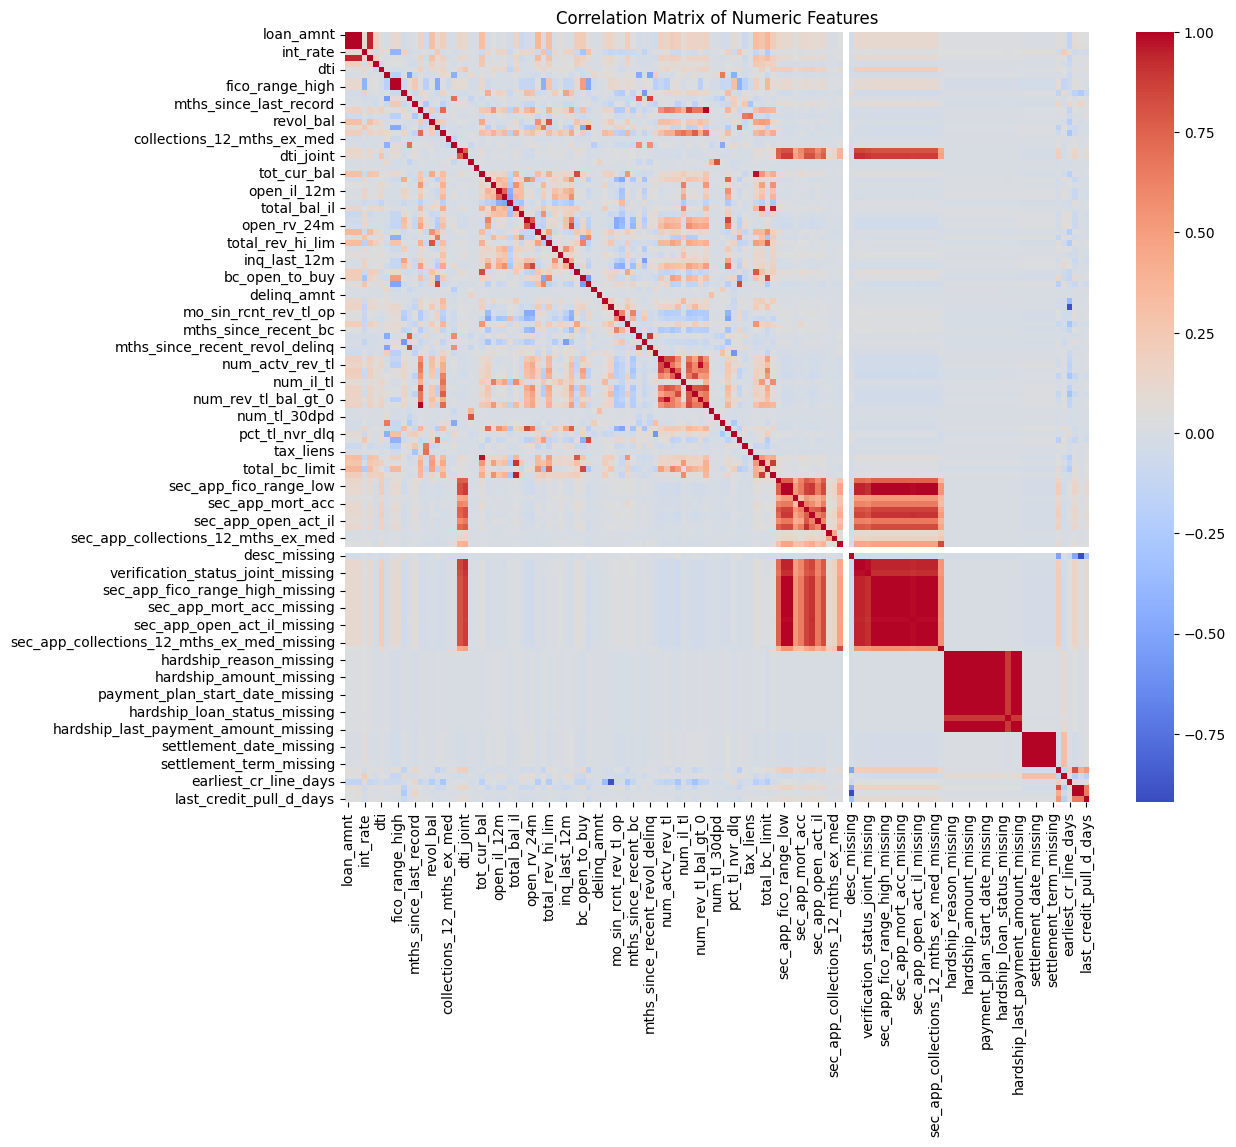


Dataset Overview (All Columns)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Columns: 149 entries, loan_amnt to last_credit_pull_d_days
dtypes: float64(95), int64(38), object(16)
memory usage: 2.5+ GB


In [10]:
import seaborn as sns

# Calculate the correlation matrix (numeric columns only for correlation)
correlation_matrix = df.corr(numeric_only=True)

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False) # Set annot=True for showing values
plt.title('Correlation Matrix of Numeric Features')
plt.show()

# Display info about all columns (numeric and non-numeric)
print("\n" + "="*80)
print("Dataset Overview (All Columns)")
print("="*80)
df.info()

#### SBERT Embedding

In [11]:

# List of text columns you want to cluster
text_columns = ["emp_title"]

# Load model once (efficient)
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

def cluster_text_column(df, column_name, n_clusters=5):
    """
    Generate clusters for a text column using SBERT + KMeans.
    Returns a pd Series containing cluster IDs.
    """
    
    # Get the column as a list
    texts = df[column_name].astype(str).tolist()
    
    # Encode into embeddings
    embeddings = model.encode(texts)
    
    # Cluster
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    labels = kmeans.fit_predict(embeddings)
    
    return labels

# Apply to each column and add result to dataframe
for col in text_columns:
    # df[col + "_cluster"] = cluster_text_column(df, col, n_clusters=5)
    df[col + "_cluster"] = cluster_text_column(df, col, n_clusters=10)
# Show result
# df.head()


In [12]:

# List of text columns you want to cluster
text_columns = ["title"]

# Load model once (efficient)
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

def cluster_text_column(df, column_name, n_clusters=5):
    """
    Generate clusters for a text column using SBERT + KMeans.
    Returns a pd Series containing cluster IDs.
    """
    
    # Get the column as a list
    texts = df[column_name].astype(str).tolist()
    
    # Encode into embeddings
    embeddings = model.encode(texts)
    
    # Cluster
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    labels = kmeans.fit_predict(embeddings)
    
    return labels

# Apply to each column and add result to dataframe
for col in text_columns:
    # df[col + "_cluster"] = cluster_text_column(df, col, n_clusters=5)
    df[col + "_cluster"] = cluster_text_column(df, col, n_clusters=10)
# Show result
# df.head()


Total unique job titles: 10000


Batches: 100%|██████████| 313/313 [01:00<00:00,  5.20it/s]


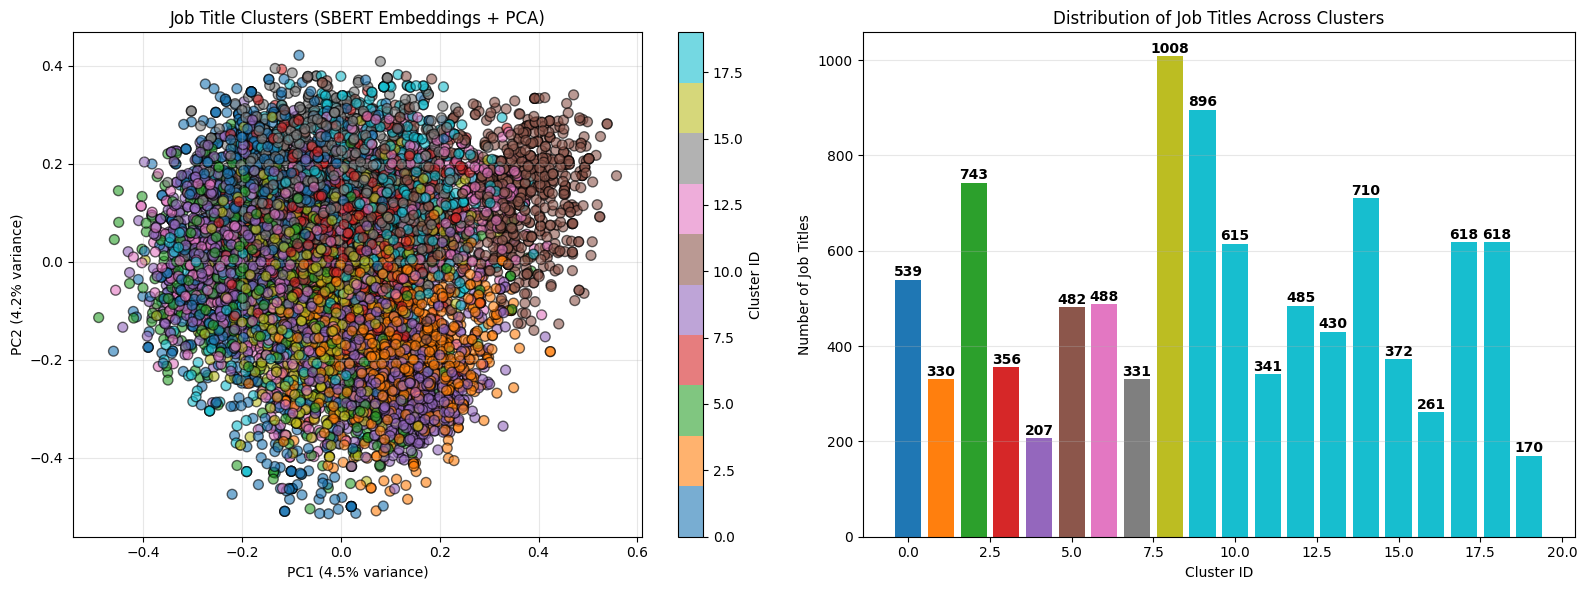


Cluster Summary:

Cluster 0 (539 titles):
Sample titles: ['Information Systems Officer', 'Executive Assistant', 'Legal Administrative Assistant', 'Senior Associate', 'Systems Administrator']

Cluster 1 (330 titles):
Sample titles: ['Sales Manager', 'Professional Sales Associate', 'Sales Representative/ Agent', 'Regional Sales Direcdtor', 'Salesman']

Cluster 2 (743 titles):
Sample titles: ['Carrier', 'PRINTER', 'Supply Chain Coord.', 'IT Help Desk Support ', 'machine operation ']

Cluster 3 (356 titles):
Sample titles: ['truck driver', 'road driver', 'mechanic', 'driver', 'Truck Driver']

Cluster 4 (207 titles):
Sample titles: ['leadman', 'Site lead', 'Lead manufacturing ', 'material handler lead', 'TEAM LEAD, QUALITY ENGINEER']

Cluster 5 (482 titles):
Sample titles: ['Executive Director', 'Director of Product Development ', 'CEO', 'Director', 'Director, Human Resources']

Cluster 6 (488 titles):
Sample titles: ['DEPUTY SHERIFF', 'Foreign Service Officer', 'Lieutenant ', 'Aviation Sa

In [13]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# Get unique job titles and their embeddings
unique_titles = df['emp_title'].fillna('unknown').unique()[:10000]
print(f"Total unique job titles: {len(unique_titles)}")

# Encode unique titles
embeddings = model.encode(unique_titles, show_progress_bar=True)

# Cluster with 20 clusters
kmeans = KMeans(n_clusters=20, random_state=0, n_init=10)
clusters = kmeans.fit_predict(embeddings)

# Reduce embeddings to 2D for visualization using PCA
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Scatter plot with clusters
scatter = axes[0].scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                         c=clusters, cmap='tab10', s=50, alpha=0.6, edgecolors='k')
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
axes[0].set_title('Job Title Clusters (SBERT Embeddings + PCA)')
cbar = plt.colorbar(scatter, ax=axes[0])
cbar.set_label('Cluster ID')
axes[0].grid(True, alpha=0.3)

# Plot 2: Cluster distribution bar chart
unique, counts = np.unique(clusters, return_counts=True)
axes[1].bar(unique, counts, color=plt.cm.tab10(unique))
axes[1].set_xlabel('Cluster ID')
axes[1].set_ylabel('Number of Job Titles')
axes[1].set_title('Distribution of Job Titles Across Clusters')
axes[1].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, v in enumerate(counts):
    axes[1].text(i, v + 1, str(v), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Print cluster summary
print("\nCluster Summary:")
print("="*60)
for cluster_id in sorted(np.unique(clusters)):
    titles_in_cluster = unique_titles[clusters == cluster_id]
    print(f"\nCluster {cluster_id} ({len(titles_in_cluster)} titles):")
    print("Sample titles:", list(titles_in_cluster[:5]))


In [14]:
for col in df.columns:
    print(col, ': ', df[col].unique() if df[col].nunique() < 1000 else 'Too many unique values', df[col].nunique(), ' | Missing Percentage: ', df[col].isna().mean())
    if df[col].nunique() > 1000:
        print(df[col].value_counts().head(10))
    

loan_amnt :  Too many unique values 1572  | Missing Percentage:  1.4597242182845055e-05
loan_amnt
10000.0    187236
20000.0    131006
15000.0    123226
12000.0    121681
35000.0     86285
5000.0      84765
8000.0      75033
6000.0      72089
25000.0     66453
16000.0     66418
Name: count, dtype: int64
funded_amnt :  Too many unique values 1572  | Missing Percentage:  1.4597242182845055e-05
funded_amnt
10000.0    187146
20000.0    130816
15000.0    123110
12000.0    121588
35000.0     86147
5000.0      84751
8000.0      75020
6000.0      72075
16000.0     66331
25000.0     66176
Name: count, dtype: int64
funded_amnt_inv :  Too many unique values 10057  | Missing Percentage:  1.4597242182845055e-05
funded_amnt_inv
10000.0    177561
20000.0    120453
15000.0    114539
12000.0    114068
5000.0      81999
35000.0     76093
8000.0      71528
6000.0      69475
16000.0     61840
25000.0     60610
Name: count, dtype: int64
term :  [' 36 months' ' 60 months' nan] 2  | Missing Percentage:  1.459

## Training

In [20]:
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Drop rows where loan_status_clean is NaN before creating X and y
df_clean = df.dropna(subset=['loan_status_clean'])

X = df_clean.drop('loan_status_clean', axis=1)
y = df_clean['loan_status_clean']

print(f"X shape before rare label handling: {X.shape}")
print(f"y shape: {y.shape}")

# === RARE LABEL ENCODING ===
# Group rare categories with low frequency
rare_label_threshold = 0.01  # 1% threshold

# Columns with many values and rare labels
rare_label_columns = {
    'grade': {'E': 'E_FG', 'F': 'E_FG', 'G': 'E_FG'},
    'purpose': {
        'other': 'other_rare',
        'major_purchase': 'other_rare',
        'medical': 'other_rare',
        'small_business': 'other_rare',
        'car': 'other_rare',
        'vacation': 'other_rare',
        'moving': 'other_rare',
        'house': 'other_rare',
        'wedding': 'other_rare',
        'renewable_energy': 'other_rare',
        'educational': 'other_rare'
    },
    'home_ownership': {'ANY': 'OTHER', 'OTHER': 'OTHER', 'NONE': 'OTHER'},
    'application_type': None  # Drop this column (95% one value)
}

# Apply rare label grouping
X_processed_labels = X.copy()

for col, mapping in rare_label_columns.items():
    if col in X_processed_labels.columns:
        if mapping is None:
            # Drop column if it's too imbalanced
            X_processed_labels = X_processed_labels.drop(columns=[col])
            print(f"Dropped column: {col} (too imbalanced)")
        else:
            # Apply mapping
            X_processed_labels[col] = X_processed_labels[col].map(mapping).fillna(X_processed_labels[col])
            print(f"Applied rare label grouping to: {col}")

# Handle addr_state - group by frequency
if 'addr_state' in X_processed_labels.columns:
    state_counts = X_processed_labels['addr_state'].value_counts()
    top_states = state_counts[state_counts > 40000].index.tolist()
    X_processed_labels['addr_state'] = X_processed_labels['addr_state'].apply(
        lambda x: x if x in top_states else 'other_states'
    )
    print(f"Grouped addr_state - kept top states: {len(top_states)}")

# Handle emp_length - group by experience level
if 'emp_length' in X_processed_labels.columns:
    emp_mapping = {
        '< 1 year': '0_2_years',
        '1 year': '0_2_years',
        '2 years': '0_2_years',
        '3 years': '3_7_years',
        '4 years': '3_7_years',
        '5 years': '3_7_years',
        '6 years': '3_7_years',
        '7 years': '7plus_years',
        '8 years': '7plus_years',
        '9 years': '7plus_years',
        '10+ years': '7plus_years'
    }
    X_processed_labels['emp_length'] = X_processed_labels['emp_length'].map(emp_mapping).fillna(X_processed_labels['emp_length'])
    print(f"Grouped emp_length into experience levels")

# Drop pymnt_plan (99.97% one value)
if 'pymnt_plan' in X_processed_labels.columns:
    X_processed_labels = X_processed_labels.drop(columns=['pymnt_plan'])
    print(f"Dropped column: pymnt_plan (99.97% imbalanced)")

print(f"\nX shape after rare label handling: {X_processed_labels.shape}")
print(f"Categorical features remaining: {X_processed_labels.select_dtypes(include='object').columns.tolist()}")

categorical_features = X_processed_labels.select_dtypes(include='object').columns.tolist()
numerical_features = X_processed_labels.select_dtypes(include=np.number).columns.tolist()

print(f"\nCategorical features: {len(categorical_features)}")
print(f"Numerical features: {len(numerical_features)}")

# === CHOOSE ENCODING METHOD ===
# After rare label grouping, most categorical features have <10 categories
# Use OrdinalEncoder for high-cardinality features (more stable than OneHotEncoder)
# Use OneHotEncoder for low-cardinality features (more interpretable)

high_cardinality_cols = [col for col in categorical_features if X_processed_labels[col].nunique() > 8]
low_cardinality_cols = [col for col in categorical_features if X_processed_labels[col].nunique() <= 8]

print(f"\nHigh cardinality (will use OrdinalEncoder): {high_cardinality_cols}")
print(f"Low cardinality (will use OneHotEncoder): {low_cardinality_cols}")

# Ensure all categorical columns are string type to avoid mixed type errors
for col in categorical_features:
    X_processed_labels[col] = X_processed_labels[col].astype(str)

# Preprocessing with pipelines for each type
transformers = [
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), numerical_features)
]

# Add low cardinality OneHotEncoder
if low_cardinality_cols:
    transformers.append(
        ('cat_ohe', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), low_cardinality_cols)
    )

# Add high cardinality ordinal encoding if there are any
if high_cardinality_cols:
    transformers.append(
        ('cat_ordinal', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
        ]), high_cardinality_cols)
    )

preprocessor = ColumnTransformer(transformers, remainder='drop')

print("\nPreprocessor created with:")
print(f"  - Numerical: StandardScaler + Median Imputation")
if low_cardinality_cols:
    print(f"  - Low cardinality: OneHotEncoder")
if high_cardinality_cols:
    print(f"  - High cardinality: OrdinalEncoder (memory efficient)")


X shape before rare label handling: (2260668, 148)
y shape: (2260668,)
Applied rare label grouping to: grade
Applied rare label grouping to: grade
Applied rare label grouping to: purpose
Applied rare label grouping to: purpose
Applied rare label grouping to: home_ownership
Applied rare label grouping to: home_ownership
Dropped column: application_type (too imbalanced)
Dropped column: application_type (too imbalanced)
Grouped addr_state - kept top states: 17
Grouped addr_state - kept top states: 17
Grouped emp_length into experience levels
Grouped emp_length into experience levels
Dropped column: pymnt_plan (99.97% imbalanced)

X shape after rare label handling: (2260668, 146)
Dropped column: pymnt_plan (99.97% imbalanced)

X shape after rare label handling: (2260668, 146)
Categorical features remaining: ['term', 'grade', 'sub_grade', 'emp_length', 'home_ownership', 'verification_status', 'purpose', 'addr_state', 'initial_list_status', 'verification_status_joint', 'sec_app_earliest_cr_l

In [22]:
columns_to_drop = ['id', 'member_id', 'zip_code', 'url', 'desc', 'policy_code']
# columns_to_drop += ['title', 'emp_title']
columns_to_drop = [c for c in columns_to_drop if c in df.columns]
df = df.drop(columns=columns_to_drop)

In [24]:
# Ensure all categorical columns are strings before preprocessing
for col in categorical_features:
    X_processed_labels[col] = X_processed_labels[col].astype(str)

X_processed = preprocessor.fit_transform(X_processed_labels)

X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

print(f"X_processed shape: {X_processed.shape}")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")


X_processed shape: (2260668, 167)
X_train shape: (1808534, 167)
X_test shape: (452134, 167)


In [28]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()

In [29]:
model.fit(X_train, y_train)

,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.",'gini'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... note:: The search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than ``max_features`` features.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",None
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow a tree with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the curre

In [31]:
from sklearn.metrics import accuracy_score

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.8958


In [38]:
import joblib


joblib.dump(model, 'dt_model_89_6%_nlp')

['dt_model_89_6%_nlp']

In [25]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression()

lr_model.fit(X_train, y_train)

c:\Users\Yusuf\Documents\Semester 9\DE\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mul

In [27]:
from sklearn.metrics import accuracy_score


y_pred = lr_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}') 


Accuracy: 0.8839


In [37]:
joblib.dump(lr_model, 'lr_model_88_4%_nlp')

['lr_model_88_4%_nlp']

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

# Perform cross-validation with preprocessed data (handles both numeric and categorical)
# First, preprocess X for cross-validation
X_processed_cv = preprocessor.fit_transform(X)

# Perform cross-validation
cv_scores = cross_val_score(
    DecisionTreeClassifier(random_state=42), 
    X_processed_cv, 
    y, 
    cv=5,  # 5-fold cross-validation
    scoring='accuracy'
)

print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean Accuracy: {cv_scores.mean():.4f}")
print(f"Standard Deviation: {cv_scores.std():.4f}")

# Also display the shapes
print(f"\nX_processed shape: {X_processed_cv.shape}")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

((2260668, 230), (1808534, 230), (452134, 230))